# Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scikeras.wrappers import KerasRegressor

# Importation des données/création des datasets

Ici, les données sont importées et on prétraite les données qualitatives de telle sorte à avoir le site de l'explosion pour chaque observation. 80% des données servent à l'entraînement et 20% servent au test. On procèdera pour chaque modèle à une validation croisée à k-plis afin de tester la robustesse des modèles.

In [2]:
Group1 = pd.read_csv('./Data/DataGroup1.csv', encoding='latin1', sep = ",")
Group2 = pd.read_csv('./Data/DataGroup2.csv', encoding='latin1', sep = ",")

Group1['Group1'] = 1
Group2['Group1'] = 0
DataFrame = pd.concat([Group1,Group2]).reset_index(drop = True)
DataFrame['ID'] = DataFrame['Name'].copy()
for obs in range(len(DataFrame)):
    DataFrame.loc[obs,'Name'] = DataFrame.loc[obs,'Name'][0:2]

numeric_columns = ['S.B','H.B','B.D','T.B','Pf','XB','E','X50']
for col in numeric_columns:
    DataFrame[col] = pd.to_numeric(DataFrame[col])


In [3]:
#Séparation en données d'entraînement et de test.
train_dataset = DataFrame.sample(frac=0.8, random_state=0)
test_dataset = DataFrame.drop(train_dataset.index)
X_train = train_dataset.copy()
X_test = test_dataset.copy()
y_train = X_train.pop('X50') #Entrainement sur x50
y_test = X_test.pop('X50') #Test sur x50'

## Informations statistiques de base

In [4]:
DataFrame[numeric_columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
S.B,104.0,1.184519,0.117075,1.00,1.1275,1.200,1.2500,1.75
H.B,104.0,3.355769,1.636197,1.33,1.8300,2.815,4.7625,6.82
B.D,104.0,27.408365,5.051351,17.98,24.7200,27.270,30.3100,39.47
T.B,104.0,1.265577,0.689299,0.50,0.8000,1.115,1.4400,4.67
Pf,104.0,0.538654,0.244461,0.22,0.3500,0.480,0.6900,1.26
XB,104.0,1.112981,0.534708,0.02,0.7450,1.055,1.5600,2.35
E,104.0,29.982692,17.995838,9.57,15.0000,16.900,45.0000,60.00
X50,104.0,0.306442,0.186734,0.02,0.1700,0.230,0.4200,0.96


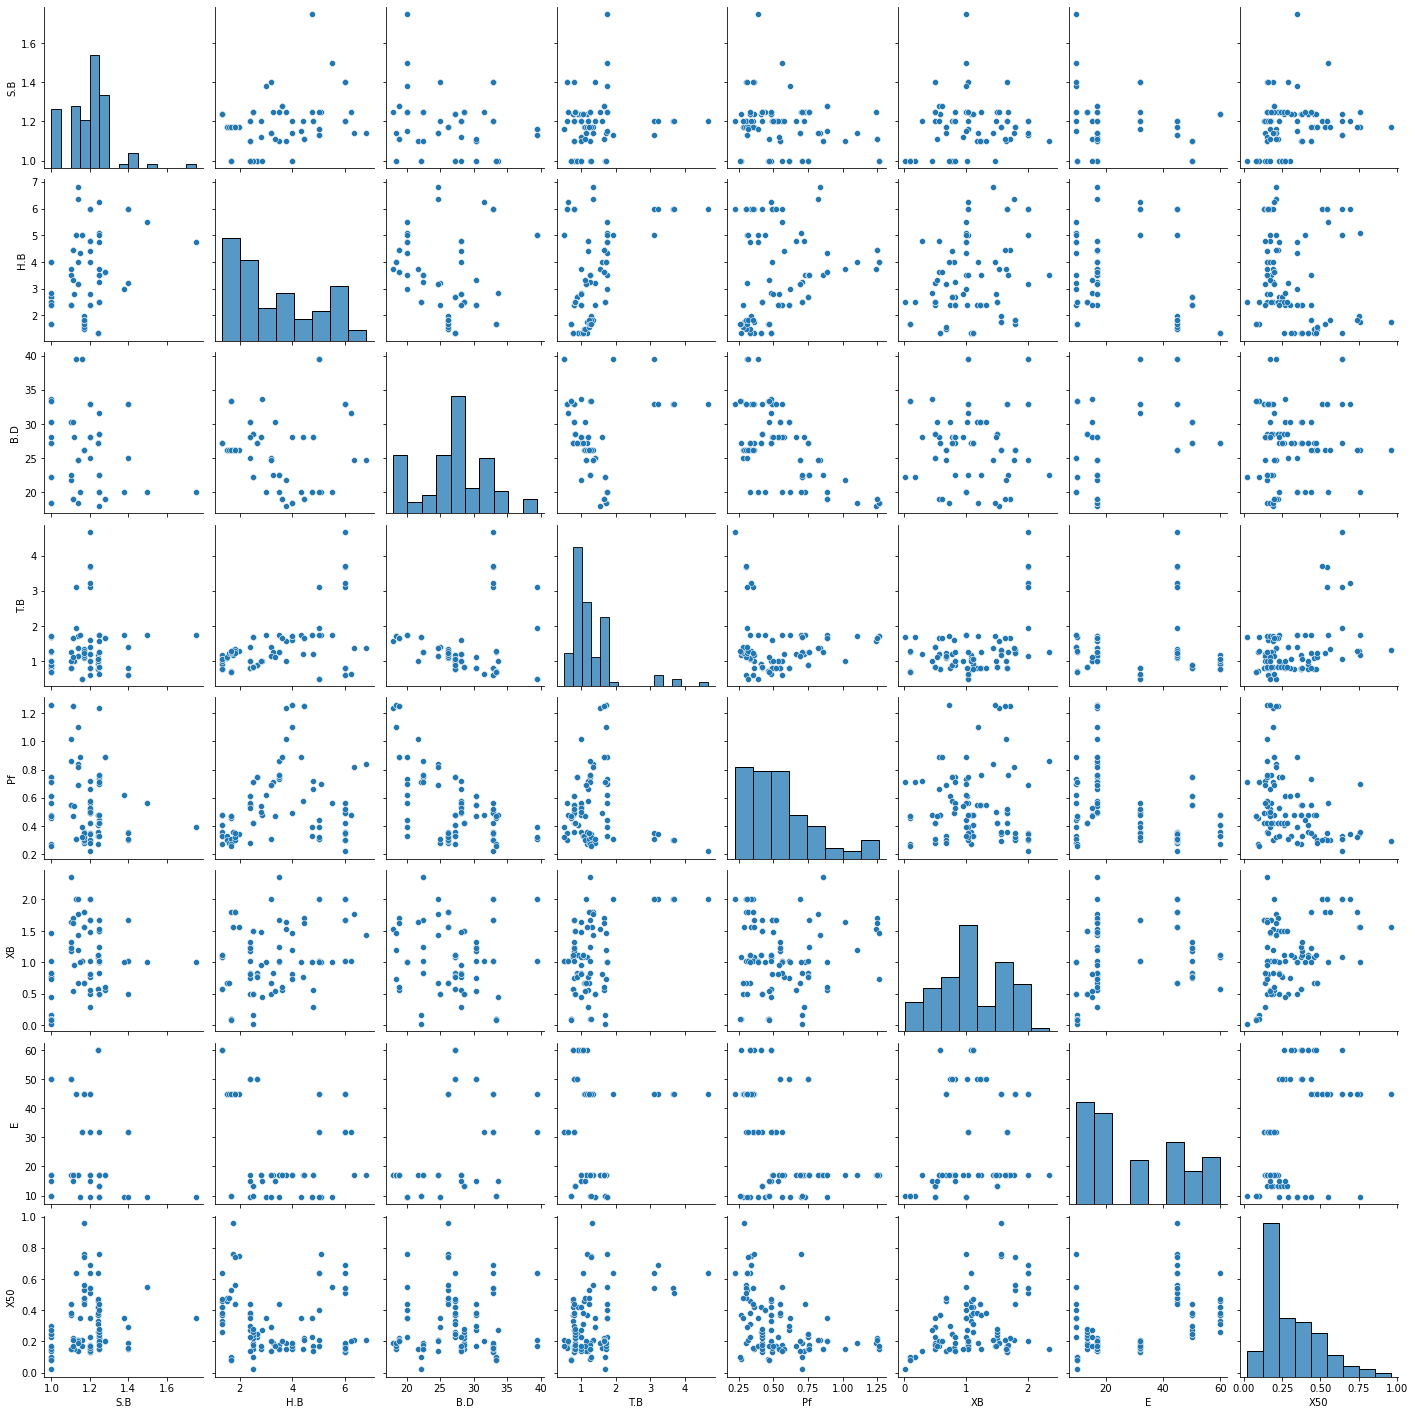

In [12]:
sns.pairplot(DataFrame[numeric_columns])

On remarque que toutes les données quantitatives sont positives et que les échelles de valeurs sont légèrement différentes. $X_{50}$ a été normalisé entre 0 et 1. De plus, toutes les données sont hautement non linéairement corrélées.

# Transformation gaussienne des données

On va transformer les données de telle sorte à ce que chaque variable suive à peu près une loi normale. Cela permet d'accélérer l'entraînement des modèles et de légèrement améliorer la précision.

In [5]:
y_train = np.log1p(y_train)

features = pd.concat([X_train, X_test]).reset_index(drop=True)
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

numeric_columns_no_label = ['S.B','H.B','B.D','T.B','Pf','XB','E']
skew_features = features[numeric_columns_no_label].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

ID = features.pop('ID')

# Encodage de la variable qualitative

Pour encoder la variable qualitative, on va procéder à du One-Hot-Encoding, ce qui permet de conserver le plus d'informations possible. Néanmoins, on craint une malédiction de la dimension au vu du nombre élevé de variables par rapport au nombre d'observations.

In [6]:
label = pd.concat([y_train,y_test]).reset_index(drop=True)
Names = features['Name']
features = pd.get_dummies(features).reset_index(drop=True)
features['ID'] = ID

Notre jeu de données ressemble maintenant à ça:

In [7]:
features

,S.B,H.B,B.D,T.B,Pf,XB,E,Group1,Name_Ad,Name_Db,Name_En,Name_Mg,Name_Mi,Name_Mr,Name_Oz,Name_Rc,Name_Ru,Name_Sm,ID
0,0.356206,2.40,30.30,0.344792,0.227081,1.18,50.0,1,0,0,0,1,0,0,0,0,0,0,Mg5
1,0.346810,1.67,33.33,0.399934,0.163287,0.10,10.0,0,0,0,0,0,1,0,0,0,0,0,Mi3
2,0.367122,1.33,27.27,0.341327,0.215897,1.08,60.0,1,0,0,1,0,0,0,0,0,0,0,En3
3,0.346810,1.67,33.33,0.326215,0.214102,0.10,10.0,0,0,0,0,0,1,0,0,0,0,0,Mi4
4,0.346810,2.40,28.09,0.373911,0.228502,0.83,16.9,0,1,0,0,0,0,0,0,0,0,0,Ad14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.359566,3.18,24.72,0.389608,0.243804,2.01,16.9,0,1,0,0,0,0,0,0,0,0,0,Ad12
100,0.356206,3.50,22.47,0.399934,0.257387,2.35,16.9,0,1,0,0,0,0,0,0,0,0,0,Ad16
101,0.367817,3.75,17.98,0.422194,0.273861,1.53,16.9,0,1,0,0,0,0,0,0,0,0,0,Ad17
102,0.357066,4.44,18.95,0.428287,0.274141,1.71,16.9,0,1,0,0,0,0,0,0,0,0,0,Ad21


# Visualisation des données

On va chercher à visualiser les données à l'aide de la matrice de corrélations ainsi que l'algorithme de t-SNE, qui permet de réduire de manière non-linéaire la dimension des données dans $\mathbb{R}^2$ tout en essayant de conserver le plus d'informations possible.

C:\Users\victo\AppData\Local\Temp/ipykernel_13064/790406255.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sub_sample_corr = df.reset_index(drop=True).corr()


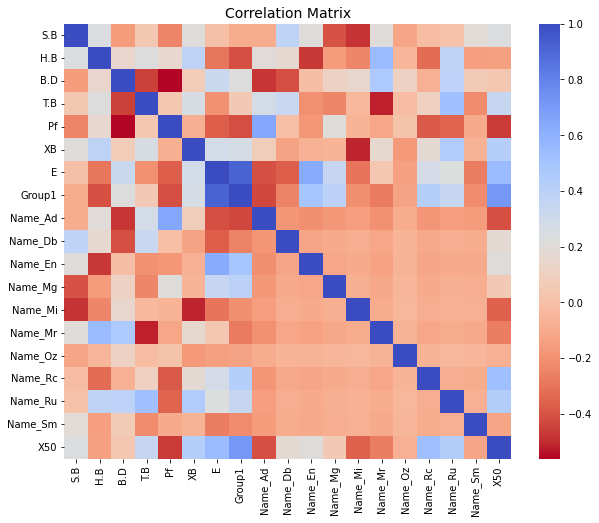

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
df = features.copy()
df['X50'] = label
f, (ax1) = plt.subplots(1, 1, figsize=(10,8))
sub_sample_corr = df.reset_index(drop=True).corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title('Correlation Matrix', fontsize=14)
plt.show()

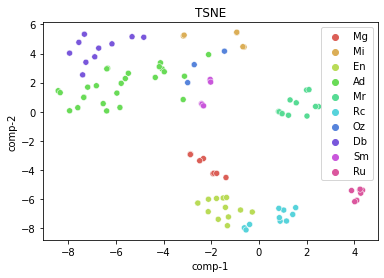

In [10]:
import time
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
tsne = TSNE()
scaler = StandardScaler()
X_tsne = tsne.fit_transform(scaler.fit_transform(df[numeric_columns]))
scikit = pd.DataFrame()
scikit["y"] = Names
scikit["comp-1"] = X_tsne[:,0]
scikit["comp-2"] = X_tsne[:,1]
sns.scatterplot(x = 'comp-1',y = 'comp-2', hue = scikit.y.tolist(), data = scikit, palette = sns.color_palette("hls", 10)).set( title="TSNE")
plt.show()

# Suppression des outliers à l'aide de boîtes à moustaches

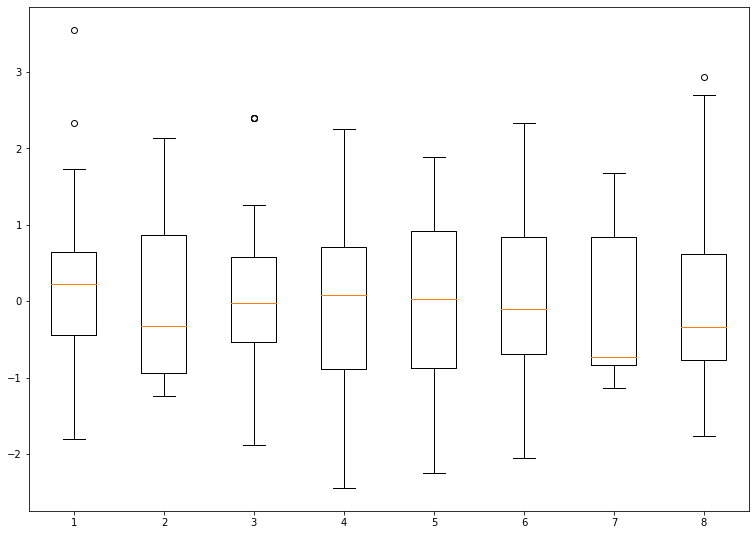

(104, 20)


In [33]:

fig = plt.figure(figsize =(10, 7))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(scaler.fit_transform(df[numeric_columns]))
 
# show plot
plt.show()

print(df.shape)



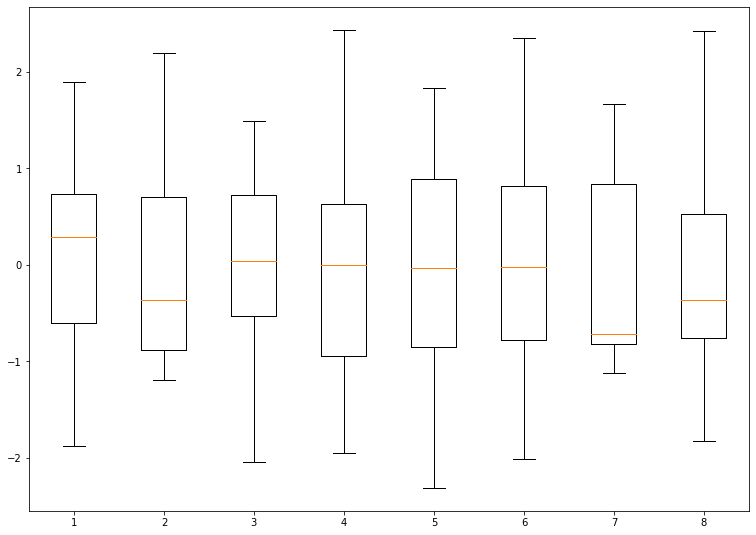

(97, 20)


In [34]:


for column in ['X50','S.B','B.D']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 

    filter = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 *IQR)
    df = df.loc[filter]  

fig = plt.figure(figsize =(10, 7))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(scaler.fit_transform(df[numeric_columns]))
 
# show plot
plt.show()

print(df.shape)

On remarque qu'après la suppression d'outliers, il n'y a pas de nouveaux outliers qui se sont rajoutés.

# Définition de la mesure de performance

Comme nous avons appliqué à notre sortie la fonction $x \to \ln(1+x)$. Nous devons lui réappliquer la bijection de cette dernière fonction avant d'appliquer l'erreur moyenne quadratique afin de pouvoir comparer notre erreur avec celle d'articles précédents.

In [15]:
from sklearn.metrics import mean_squared_error
def metric_train(y_pred,y_true):
    y_pred_exp = np.expm1(y_pred)
    y_true_exp = np.expm1(y_true)
    return mean_squared_error(y_pred_exp,y_true_exp)
from sklearn.metrics import make_scorer

my_scorer = make_scorer(metric_train, greater_is_better=False)

In [14]:
label = df.pop('X50')
features = df
df

,S.B,H.B,B.D,T.B,Pf,XB,E,Group1,Name_Ad,Name_Db,Name_En,Name_Mg,Name_Mi,Name_Mr,Name_Oz,Name_Rc,Name_Ru,Name_Sm,ID
0,0.356206,2.40,30.30,0.344792,0.227081,1.18,50.0,1,0,0,0,1,0,0,0,0,0,0,Mg5
1,0.346810,1.67,33.33,0.399934,0.163287,0.10,10.0,0,0,0,0,0,1,0,0,0,0,0,Mi3
2,0.367122,1.33,27.27,0.341327,0.215897,1.08,60.0,1,0,0,1,0,0,0,0,0,0,0,En3
3,0.346810,1.67,33.33,0.326215,0.214102,0.10,10.0,0,0,0,0,0,1,0,0,0,0,0,Mi4
4,0.346810,2.40,28.09,0.373911,0.228502,0.83,16.9,0,1,0,0,0,0,0,0,0,0,0,Ad14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.359566,3.18,24.72,0.389608,0.243804,2.01,16.9,0,1,0,0,0,0,0,0,0,0,0,Ad12
100,0.356206,3.50,22.47,0.399934,0.257387,2.35,16.9,0,1,0,0,0,0,0,0,0,0,0,Ad16
101,0.367817,3.75,17.98,0.422194,0.273861,1.53,16.9,0,1,0,0,0,0,0,0,0,0,0,Ad17
102,0.357066,4.44,18.95,0.428287,0.274141,1.71,16.9,0,1,0,0,0,0,0,0,0,0,0,Ad21


# Séléction de caractéristiques à l'aide d'arbres de décisions (XGBoost, LGBM)

Nous allons entraîner deux arbres de décisions en optimisant leurs hyperparamètres afin d'avoir accès à l'important de chaque variable pour un arbre de décision performant.

## XGBOOST

In [ ]:
import xgboost as xb
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import average_precision_score
import numpy as np
from scipy import stats
model = xb.XGBRegressor(booster = 'gbtree') #objective = 'reg:logistic',
hyperparameter_grid = {
    'n_estimators': [10,50,100,1000,5000],
    'max_depth':stats.randint(5,50),
    'learning_rate': stats.loguniform(1e-4,1),
    'min_child_weight':stats.randint(1,30),
    'subsample':stats.uniform(0,1),
    'colsample_bytree':stats.uniform(0,1),
    'gamma':stats.uniform(0,1),
    'reg_lambda':stats.uniform(0,5),
    'alpha':stats.uniform(0,5)
    }
random_cv = RandomizedSearchCV(estimator=model,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=1000,
            scoring = my_scorer,n_jobs = 1,
            return_train_score = True, verbose = 10,
            random_state=42)
random_cv.fit(features,label)


In [16]:
print(random_cv.best_params_)
results = pd.DataFrame(random_cv.cv_results_)
results.sort_values('rank_test_score')

{'alpha': 0.06077237344908171, 'colsample_bytree': 0.969878826707639, 'gamma': 0.04315991195057611, 'learning_rate': 0.366920903969591, 'max_depth': 25, 'min_child_weight': 11, 'n_estimators': 1000, 'reg_lambda': 0.3689828236769943, 'subsample': 0.5538542844013208}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
58,0.342618,0.007756,0.005327,0.006686,0.060772,0.969879,0.04316,0.366921,25,11,...,-0.012049,0.005484,1,-0.006769,-0.008488,-0.007614,-0.007787,-0.008264,-0.007784,0.000597
895,0.047214,0.002429,0.002248,0.004496,0.952067,0.669953,0.000402,0.167326,26,5,...,-0.012658,0.006645,2,-0.008230,-0.009380,-0.009197,-0.009863,-0.009943,-0.009323,0.000615
422,1.660507,0.020368,0.000201,0.000403,0.663223,0.511636,0.005346,0.567094,9,21,...,-0.014025,0.006543,3,-0.009680,-0.011854,-0.011082,-0.012078,-0.011184,-0.011175,0.000839
932,2.110061,0.049304,0.006250,0.007655,2.868139,0.821536,0.028571,0.033374,11,1,...,-0.017374,0.005034,4,-0.012576,-0.016090,-0.013067,-0.015219,-0.015519,-0.014494,0.001403
430,0.046201,0.001785,0.005328,0.006686,0.158719,0.423335,0.084565,0.026754,20,14,...,-0.017531,0.005782,5,-0.012052,-0.015939,-0.014149,-0.015530,-0.014716,-0.014477,0.001363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.041856,0.004658,0.004034,0.003627,2.792063,0.22554,0.160825,0.040372,6,24,...,-0.151603,0.029611,893,-0.154281,-0.139943,-0.161601,-0.156240,-0.147807,-0.151974,0.007461
153,1.611215,0.021866,0.006027,0.007389,4.343116,0.776597,0.770922,0.239405,11,3,...,-0.151603,0.029611,893,-0.154281,-0.139943,-0.161601,-0.156240,-0.147807,-0.151974,0.007461
716,0.019001,0.006870,0.000000,0.000000,1.529474,0.483135,0.063183,0.027833,47,25,...,-0.151603,0.029611,893,-0.154281,-0.139943,-0.161601,-0.156240,-0.147807,-0.151974,0.007461
561,0.014589,0.002051,0.001204,0.001508,0.094727,0.735918,0.2084,0.00034,7,16,...,-0.151603,0.029611,893,-0.154281,-0.139943,-0.161601,-0.156240,-0.147807,-0.151974,0.007461


<AxesSubplot:>

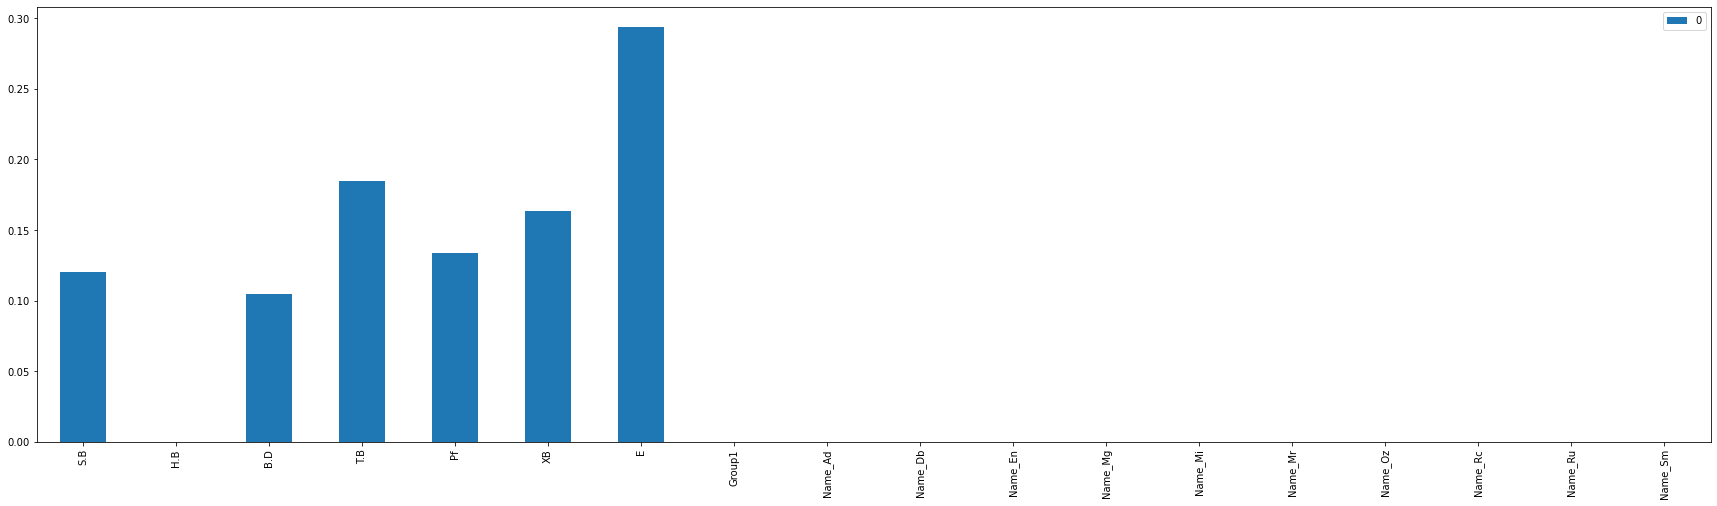

In [17]:
pd.DataFrame(random_cv.best_estimator_.feature_importances_, index=features.columns).plot.bar(figsize=(30, 8))

On constate que les variables qualitatives n'ont aucune importance.

## LGBM

In [ ]:
import lightgbm as lgb
from scipy import stats
model = lgb.LGBMRegressor()
params = {} #initialize parameters
params['learning_rate'] = stats.loguniform(1e-4, 1)
params['boosting_type'] = ['gbdt', 'dart', 'goss']
params['objective'] = ['regression']
params['sub_feature'] = stats.uniform(0, 1)
params['num_leaves'] = stats.randint(20, 300)
params['min_data'] = stats.randint(10, 100)
params['max_depth'] = stats.randint(5, 200)
params['reg_alpha']  = stats.uniform(0,5)
params['reg_lambda'] = stats.uniform(0,5)
random_cv_lgb = RandomizedSearchCV(estimator=model,
            param_distributions=params,
            cv=5, n_iter=1000,
            scoring = my_scorer,n_jobs = 1,
            return_train_score = True, verbose = 0,
            random_state=42)
random_cv_lgb.fit(features,label)


In [19]:
print(random_cv_lgb.best_params_)
results = pd.DataFrame(random_cv_lgb.cv_results_)
results.sort_values('rank_test_score')

{'boosting_type': 'gbdt', 'learning_rate': 0.12549039293747366, 'max_depth': 152, 'min_data': 14, 'num_leaves': 298, 'objective': 'regression', 'reg_alpha': 0.5737097916909595, 'reg_lambda': 0.6306882900807603, 'sub_feature': 0.5295336150224574}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_learning_rate,param_max_depth,param_min_data,param_num_leaves,param_objective,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
925,0.016905,0.002617,0.001903,0.003806,gbdt,0.12549,152,14,298,regression,...,-0.012217,0.005968,1,-0.007117,-0.009319,-0.007456,-0.008857,-0.008808,-0.008311,0.000862
62,0.007230,0.006909,0.006465,0.007926,gbdt,0.225904,178,22,187,regression,...,-0.012449,0.005157,2,-0.006107,-0.009800,-0.007080,-0.008683,-0.008643,-0.008063,0.001306
550,0.021932,0.007427,0.003125,0.006250,gbdt,0.072279,17,16,63,regression,...,-0.013078,0.005719,3,-0.007928,-0.010672,-0.008042,-0.009609,-0.009040,-0.009058,0.001022
825,0.016742,0.005178,0.001102,0.002204,goss,0.925758,105,11,263,regression,...,-0.014079,0.005230,4,-0.008315,-0.007026,-0.008186,-0.008368,-0.007268,-0.007833,0.000568
266,0.010321,0.006877,0.008557,0.007148,gbdt,0.561762,33,22,277,regression,...,-0.014218,0.005801,5,-0.008367,-0.012158,-0.009520,-0.010210,-0.010101,-0.010071,0.001231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,0.019157,0.006267,0.003479,0.006957,dart,0.000111,125,10,121,regression,...,-0.222778,0.047222,996,-0.155026,-0.305781,-0.214865,-0.203239,-0.247117,-0.225206,0.049974
646,0.018736,0.005722,0.003002,0.006004,dart,0.001421,45,15,268,regression,...,-0.227663,0.050275,997,-0.250977,-0.257815,-0.207963,-0.207736,-0.211950,-0.227288,0.022289
212,0.013002,0.005245,0.000000,0.000000,dart,0.403183,145,32,148,regression,...,-0.234912,0.058951,998,-0.207396,-0.338134,-0.230881,-0.217982,-0.184074,-0.235693,0.053472
989,0.012211,0.004977,0.002902,0.005804,dart,0.001935,103,19,289,regression,...,-0.237706,0.071722,999,-0.262920,-0.234888,-0.255071,-0.204156,-0.216552,-0.234717,0.022242


<AxesSubplot:>

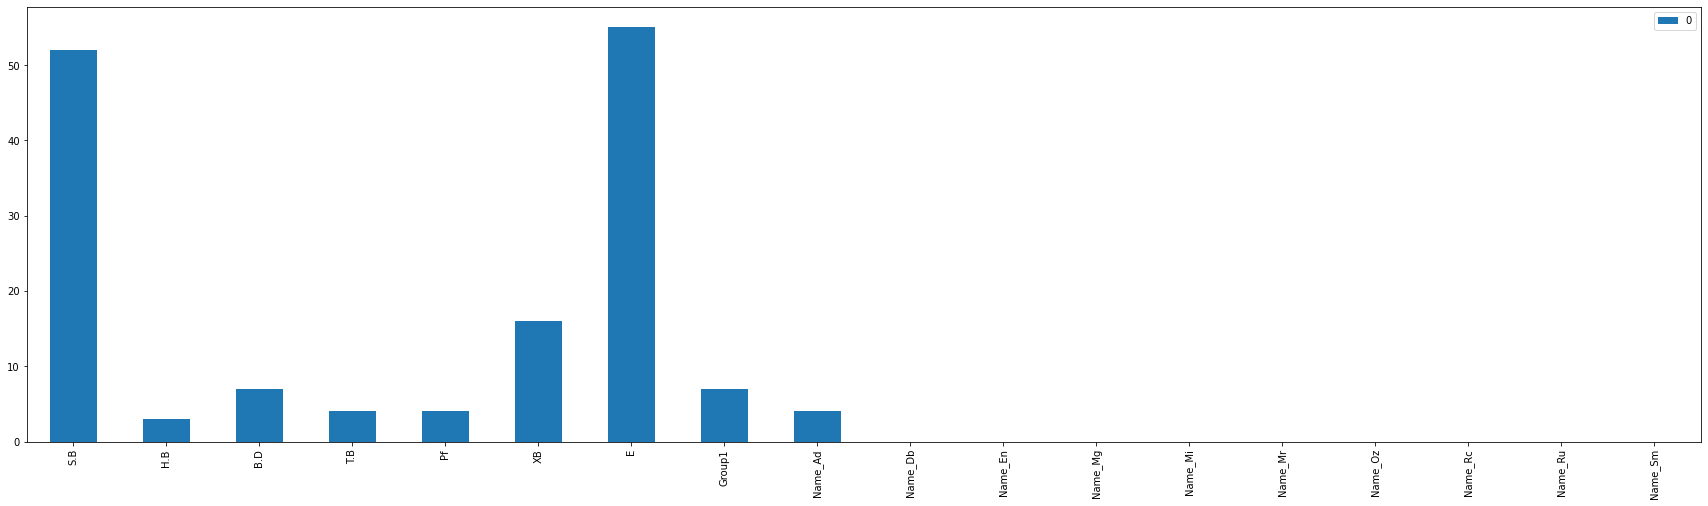

In [20]:
pd.DataFrame(random_cv_lgb.best_estimator_.feature_importances_, index=features.columns).plot.bar(figsize=(30, 8))


Idem ici, mis à part une légère importance pour Group1 et Name_Ad. D'où la conservation de ces deux variables

In [17]:
features = features[['S.B','B.D','H.B','T.B','Pf','XB','E','Name_Ad', 'Group1']]

## Modèles de prédiction

Nous allons maintenant pouvoir tester différents modèles afin de pouvoir prédire la taille médiane des fragments. Nous allons ainsi tester: XGBoost, LGBM ElasticNet, un réseau de neurones (optimisé en dehors de ce notebook), un SVR et un modèle de stacking.

## XGB

In [21]:
import xgboost as xb
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import average_precision_score
import numpy as np
from scipy import stats
model = xb.XGBRegressor(booster = 'gbtree') #objective = 'reg:logistic',
hyperparameter_grid = {
    'n_estimators': [10,50,100,1000,5000],
    'max_depth':stats.randint(5,50),
    'learning_rate': stats.loguniform(1e-4,1),
    'min_child_weight':stats.randint(1,30),
    'subsample':stats.uniform(0,1),
    'colsample_bytree':stats.uniform(0,1),
    'gamma':stats.uniform(0,1),
    'reg_lambda':stats.uniform(0,5),
    'alpha':stats.uniform(0,5)
    }
random_cv = RandomizedSearchCV(estimator=model,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=1000,
            scoring = my_scorer,n_jobs = 1,
            return_train_score = True, verbose = 0,
            random_state=42)
random_cv.fit(features,label)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster='gbtree',
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_r...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025D3D2271C0>,
                                        'n_estimators': [10, 50, 100, 1000,
                                                         5000],
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025D3D22E730>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025D3807CA90>},
                   random_state=42, return_train_score=True,
                   scoring=make_scorer(metric_train, greater_is_better=False))

In [22]:
print(random_cv.best_params_)
results = pd.DataFrame(random_cv.cv_results_)
results.sort_values('rank_test_score')

{'alpha': 0.06077237344908171, 'colsample_bytree': 0.969878826707639, 'gamma': 0.04315991195057611, 'learning_rate': 0.366920903969591, 'max_depth': 25, 'min_child_weight': 11, 'n_estimators': 1000, 'reg_lambda': 0.3689828236769943, 'subsample': 0.5538542844013208}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
58,0.290368,0.006088,0.002432,0.004088,0.060772,0.969879,0.04316,0.366921,25,11,...,-0.012294,0.005873,1,-0.006041,-0.008488,-0.006880,-0.007787,-0.008510,-0.007541,0.000957
895,0.032263,0.004537,0.006253,0.007658,0.952067,0.669953,0.000402,0.167326,26,5,...,-0.014014,0.006438,2,-0.008462,-0.009924,-0.009389,-0.010786,-0.011936,-0.010099,0.001188
422,1.261081,0.009195,0.005583,0.005742,0.663223,0.511636,0.005346,0.567094,9,21,...,-0.014145,0.006125,3,-0.009313,-0.011096,-0.011564,-0.012352,-0.011568,-0.011179,0.001016
5,0.252097,0.013147,0.001993,0.002450,0.610191,0.495177,0.034389,0.433792,40,18,...,-0.017072,0.007347,4,-0.012786,-0.015022,-0.014657,-0.015460,-0.013351,-0.014255,0.001018
430,0.047151,0.000184,0.000000,0.000000,0.158719,0.423335,0.084565,0.026754,20,14,...,-0.017411,0.005589,5,-0.011747,-0.016385,-0.014178,-0.015951,-0.014796,-0.014612,0.001635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.028922,0.007903,0.006566,0.007421,2.792063,0.22554,0.160825,0.040372,6,24,...,-0.151603,0.029611,893,-0.154281,-0.139943,-0.161601,-0.156240,-0.147807,-0.151974,0.007461
153,1.197891,0.011283,0.007409,0.007440,4.343116,0.776597,0.770922,0.239405,11,3,...,-0.151603,0.029611,893,-0.154281,-0.139943,-0.161601,-0.156240,-0.147807,-0.151974,0.007461
716,0.025036,0.007508,0.000000,0.000000,1.529474,0.483135,0.063183,0.027833,47,25,...,-0.151603,0.029611,893,-0.154281,-0.139943,-0.161601,-0.156240,-0.147807,-0.151974,0.007461
561,0.006252,0.007658,0.006352,0.007781,0.094727,0.735918,0.2084,0.00034,7,16,...,-0.151603,0.029611,893,-0.154281,-0.139943,-0.161601,-0.156240,-0.147807,-0.151974,0.007461


<AxesSubplot:>

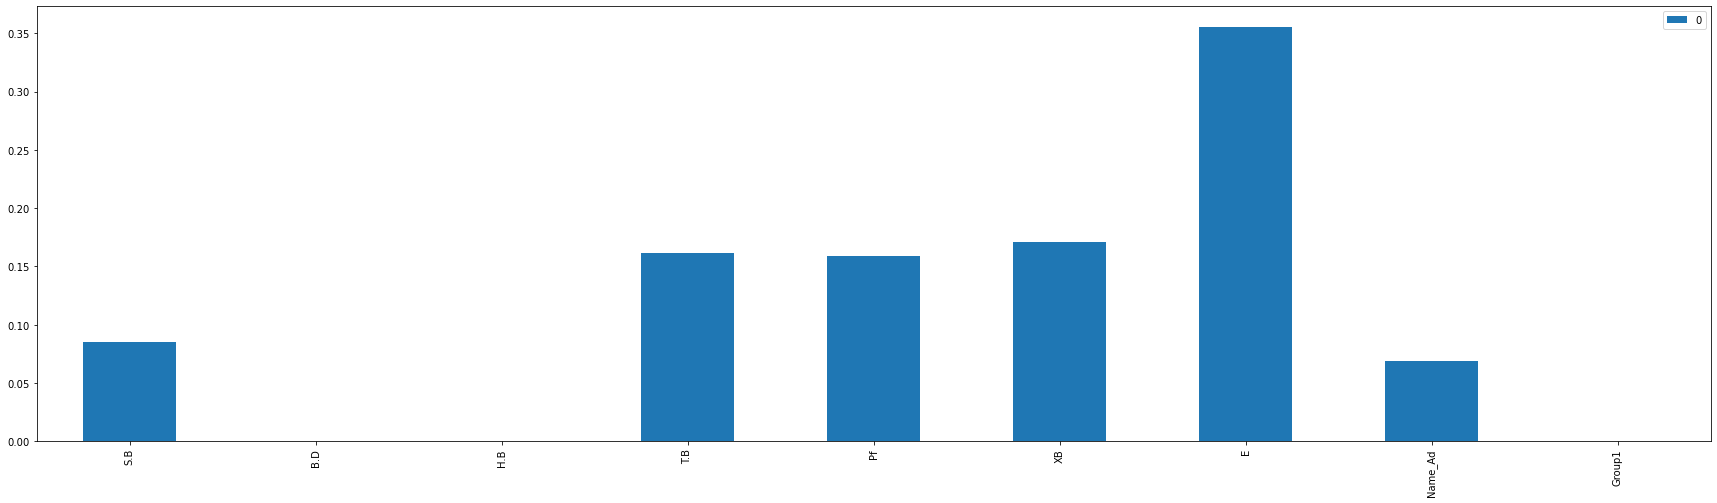

In [23]:
pd.DataFrame(random_cv.best_estimator_.feature_importances_, index=features.columns).plot.bar(figsize=(30, 8))


## LGBM

In [ ]:
import lightgbm as lgb
from scipy import stats
model = lgb.LGBMRegressor()
params = {} #initialize parameters
params['learning_rate'] = stats.loguniform(1e-4, 1)
params['boosting_type'] = ['gbdt', 'dart', 'goss']
params['objective'] = ['regression']
params['sub_feature'] = stats.uniform(0, 1)
params['num_leaves'] = stats.randint(20, 300)
params['min_data'] = stats.randint(10, 100)
params['max_depth'] = stats.randint(5, 200)
params['reg_alpha']  = stats.uniform(0,5)
params['reg_lambda'] = stats.uniform(0,5)
random_cv_lgb = RandomizedSearchCV(estimator=model,
            param_distributions=params,
            cv=3, n_iter=1000,
            scoring = my_scorer,n_jobs = 1,
            return_train_score = True, verbose = 0,
            random_state=42)
random_cv_lgb.fit(features,label)


In [25]:
print(random_cv_lgb.best_params_)
results = pd.DataFrame(random_cv_lgb.cv_results_)
results.sort_values('rank_test_score')

{'boosting_type': 'gbdt', 'learning_rate': 0.12549039293747366, 'max_depth': 152, 'min_data': 14, 'num_leaves': 298, 'objective': 'regression', 'reg_alpha': 0.5737097916909595, 'reg_lambda': 0.6306882900807603, 'sub_feature': 0.5295336150224574}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_learning_rate,param_max_depth,param_min_data,param_num_leaves,param_objective,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
925,0.010556,0.007466,0.005209,0.007366,gbdt,0.12549,152,14,298,regression,...,-0.011631,-0.010470,-0.013095,0.002930,1,-0.008869,-0.008644,-0.010529,-0.009347,0.000840
550,0.020879,0.007418,0.000000,0.000000,gbdt,0.072279,17,16,63,regression,...,-0.012159,-0.010621,-0.013259,0.002716,2,-0.009433,-0.009219,-0.010709,-0.009787,0.000658
62,0.015626,0.000001,0.000000,0.000000,gbdt,0.225904,178,22,187,regression,...,-0.015035,-0.010061,-0.014208,0.003104,3,-0.007254,-0.013002,-0.011364,-0.010540,0.002418
825,0.015690,0.000792,0.003199,0.000295,goss,0.925758,105,11,263,regression,...,-0.015906,-0.010826,-0.014800,0.002901,4,-0.008243,-0.013420,-0.012774,-0.011479,0.002303
258,0.016039,0.000576,0.000000,0.000000,gbdt,0.015793,100,17,157,regression,...,-0.015336,-0.013463,-0.015380,0.001585,5,-0.011641,-0.012561,-0.014005,-0.012736,0.000973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,0.026971,0.006227,0.000000,0.000000,dart,0.00326,34,18,81,regression,...,-0.298495,-0.190623,-0.224592,0.052314,996,-0.213935,-0.262789,-0.190992,-0.222572,0.029941
171,0.015761,0.000183,0.000000,0.000000,dart,0.615448,196,26,31,regression,...,-0.262622,-0.205523,-0.225933,0.025998,997,-0.238166,-0.217983,-0.200917,-0.219022,0.015225
290,0.020603,0.007829,0.000436,0.000616,dart,0.083808,62,30,101,regression,...,-0.273054,-0.249248,-0.233269,0.040611,998,-0.208155,-0.239201,-0.248889,-0.232082,0.017375
453,0.015624,0.000001,0.000000,0.000000,dart,0.000111,125,10,121,regression,...,-0.252022,-0.219999,-0.234134,0.013340,999,-0.263471,-0.219354,-0.220624,-0.234483,0.020504


<AxesSubplot:>

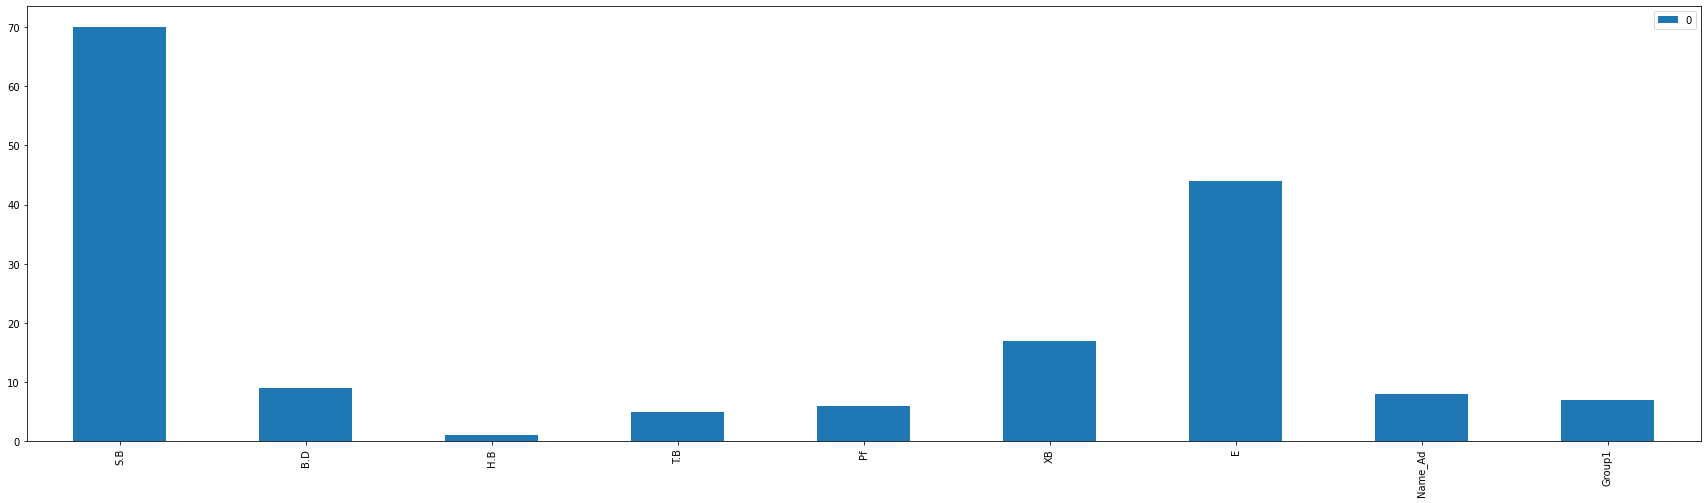

In [26]:
pd.DataFrame(random_cv_lgb.best_estimator_.feature_importances_, index=features.columns).plot.bar(figsize=(30, 8))

## SVR

In [27]:
from sklearn.svm import SVR
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
scaler = RobustScaler()
model = SVR(kernel = 'rbf')
pipeline = Pipeline(steps = [('scaler',scaler),('model',model)])
params = {} #initialize parameters
params['model__C'] = stats.loguniform(1e-2, 1e2)
params['model__gamma'] = stats.loguniform(1e-4,5e-1)
params['model__epsilon'] = stats.loguniform(1e-5,1)
random_cv_svm = RandomizedSearchCV(estimator=pipeline,
            param_distributions=params,
            cv=5, n_iter=1000,
            scoring = my_scorer,n_jobs = 1,
            return_train_score = True, verbose = 0,
            random_state=42)
random_cv_svm.fit(features,label)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model', SVR())]),
                   n_iter=1000, n_jobs=1,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025D3D34E130>,
                                        'model__epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025D38B764C0>,
                                        'model__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025D3D1CFD00>},
                   random_state=42, return_train_score=True,
                   scoring=make_scorer(metric_train, greater_is_better=False))

In [28]:
print(random_cv_svm.best_params_)
results = pd.DataFrame(random_cv_svm.cv_results_)
results.sort_values('rank_test_score')

{'model__C': 0.6229347004284251, 'model__epsilon': 0.040771312371951314, 'model__gamma': 0.18967566261573762}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__epsilon,param_model__gamma,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
638,0.006235,0.007636,0.000000,0.000000,0.622935,0.040771,0.189676,"{'model__C': 0.6229347004284251, 'model__epsil...",-0.014883,-0.003484,...,-0.007682,0.004050,1,-0.003222,-0.004686,-0.003926,-0.004100,-0.004746,-0.004136,0.000558
711,0.006304,0.006150,0.000343,0.000687,1.287059,0.039516,0.196353,"{'model__C': 1.2870590967923814, 'model__epsil...",-0.015536,-0.004444,...,-0.007778,0.004069,2,-0.003033,-0.003554,-0.003522,-0.003444,-0.003775,-0.003466,0.000242
538,0.001210,0.002420,0.004636,0.006227,0.214787,0.022255,0.475655,"{'model__C': 0.2147868319058961, 'model__epsil...",-0.013983,-0.003978,...,-0.007781,0.003543,3,-0.002985,-0.003913,-0.003849,-0.003771,-0.003955,-0.003695,0.000360
147,0.008484,0.004945,0.000000,0.000000,88.421589,0.000744,0.00235,"{'model__C': 88.42158875126609, 'model__epsilo...",-0.012674,-0.002923,...,-0.007791,0.004086,4,-0.005050,-0.007065,-0.005512,-0.006352,-0.006701,-0.006136,0.000748
954,0.006205,0.000608,0.001882,0.000416,63.363139,0.008093,0.004121,"{'model__C': 63.363138752857196, 'model__epsil...",-0.012874,-0.002772,...,-0.007819,0.004140,5,-0.004822,-0.006619,-0.005200,-0.005950,-0.006364,-0.005791,0.000682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,0.003794,0.001297,0.002776,0.001168,0.050221,0.215701,0.001109,"{'model__C': 0.050221200319557076, 'model__eps...",-0.031607,-0.052022,...,-0.036797,0.007755,996,-0.035119,-0.037768,-0.031494,-0.033601,-0.035050,-0.034606,0.002057
765,0.001220,0.002175,0.003125,0.006250,0.010731,0.000125,0.000137,"{'model__C': 0.010731393763781539, 'model__eps...",-0.037146,-0.023451,...,-0.036816,0.013517,997,-0.036787,-0.035705,-0.032833,-0.033885,-0.036543,-0.035151,0.001543
481,0.002810,0.005620,0.003126,0.006252,0.595663,0.219135,0.000452,"{'model__C': 0.5956633466901677, 'model__epsil...",-0.031828,-0.048587,...,-0.036838,0.006029,998,-0.035861,-0.036521,-0.032609,-0.033878,-0.036031,-0.034980,0.001489
349,0.002811,0.005621,0.006527,0.008004,0.01252,0.224127,0.00012,"{'model__C': 0.012519965329664595, 'model__eps...",-0.032649,-0.050168,...,-0.036887,0.006703,999,-0.036293,-0.036792,-0.032804,-0.034061,-0.036201,-0.035230,0.001534


## ElsaticNet

In [ ]:
from sklearn.linear_model import ElasticNet

# Use grid search to tune the parameters:
scaler = RobustScaler()
params = {"model__max_iter":stats.randint(50,1000),
                      "model__alpha": stats.loguniform(1e-4,1e2),
                      "model__l1_ratio": stats.uniform(0,1)}

model = ElasticNet()
pipeline = Pipeline(steps = [('scaler',scaler),('model',model)])
random_cv_enet = RandomizedSearchCV(estimator=pipeline,
        param_distributions=params,
        cv=5, n_iter=1000,
        scoring = my_scorer,n_jobs = 1,
        return_train_score = True, verbose = 0,
        random_state=42)
random_cv_enet.fit(features, label)


In [31]:
print(random_cv_enet.best_params_)
results = pd.DataFrame(random_cv_enet.cv_results_)
results.sort_values('rank_test_score')


{'model__alpha': 0.00010325362018342093, 'model__l1_ratio': 0.04416193617783126, 'model__max_iter': 341}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__l1_ratio,param_model__max_iter,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
995,0.003125,0.006251,0.003136,0.006271,0.000103,0.044162,341,"{'model__alpha': 0.00010325362018342093, 'mode...",-0.016251,-0.003983,...,-0.008409,0.004438,1,-0.004807,-0.007302,-0.005924,-0.006573,-0.007092,-0.006340,0.000902
774,0.001810,0.003620,0.003136,0.006272,0.000144,0.024192,303,"{'model__alpha': 0.00014360853478684457, 'mode...",-0.016258,-0.003967,...,-0.008409,0.004443,2,-0.004808,-0.007304,-0.005924,-0.006574,-0.007094,-0.006341,0.000902
782,0.005635,0.006970,0.003124,0.006249,0.00011,0.05728,735,"{'model__alpha': 0.00011019838324235974, 'mode...",-0.016256,-0.003977,...,-0.008409,0.004441,3,-0.004807,-0.007303,-0.005924,-0.006573,-0.007093,-0.006340,0.000902
208,0.003126,0.006251,0.003126,0.006252,0.000121,0.075359,525,"{'model__alpha': 0.00012079022464380833, 'mode...",-0.016264,-0.003968,...,-0.008410,0.004444,4,-0.004808,-0.007304,-0.005925,-0.006574,-0.007094,-0.006341,0.000902
265,0.005944,0.007298,0.003125,0.006250,0.000204,0.018242,278,"{'model__alpha': 0.00020408583715828934, 'mode...",-0.016272,-0.003941,...,-0.008410,0.004451,5,-0.004810,-0.007308,-0.005926,-0.006576,-0.007096,-0.006343,0.000903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,0.006031,0.005535,0.000000,0.000000,7.987896,0.257903,553,"{'model__alpha': 7.9878964385499485, 'model__l...",-0.029756,-0.029124,...,-0.032179,0.007165,512,-0.031170,-0.031159,-0.028300,-0.030046,-0.032617,-0.030659,0.001434
617,0.005868,0.006656,0.003126,0.006252,16.426981,0.472892,710,"{'model__alpha': 16.426980738424568, 'model__l...",-0.029756,-0.029124,...,-0.032179,0.007165,512,-0.031170,-0.031159,-0.028300,-0.030046,-0.032617,-0.030659,0.001434
615,0.000990,0.001980,0.003136,0.006272,3.980493,0.149704,488,"{'model__alpha': 3.9804925113595107, 'model__l...",-0.029756,-0.029124,...,-0.032179,0.007165,512,-0.031170,-0.031159,-0.028300,-0.030046,-0.032617,-0.030659,0.001434
632,0.002238,0.002819,0.005447,0.006798,0.360472,0.680132,861,"{'model__alpha': 0.3604723434492399, 'model__l...",-0.029756,-0.029124,...,-0.032179,0.007165,512,-0.031170,-0.031159,-0.028300,-0.030046,-0.032617,-0.030659,0.001434


## StackingCVRegressor

In [ ]:
from sklearn.svm import SVR
import xgboost as xb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

xgb = xb.XGBRegressor(alpha= 0.06077237344908171, colsample_bytree= 0.969878826707639, gamma= 0.04315991195057611, learning_rate= 0.366920903969591, max_depth= 25, min_child_weight= 11, n_estimators= 1000, reg_lambda= 0.3689828236769943, subsample= 0.5538542844013208)
lgbm = lgb.LGBMRegressor(boosting_type= 'gbdt', learning_rate= 0.12549039293747366, max_depth= 152, min_data= 14, num_leaves= 298, objective='regression', reg_alpha= 0.5737097916909595, reg_lambda= 0.6306882900807603, sub_feature= 0.5295336150224574)
svr = SVR(kernel = 'rbf', C= 0.6229347004284251, epsilon= 0.040771312371951314, gamma=0.18967566261573762)
enet = ElasticNet(alpha= 0.00010325362018342093, l1_ratio= 0.04416193617783126, max_iter= 341) 
  
scaler = RobustScaler()
pip_svr = Pipeline(steps = [('scaler',scaler),('model',svr)])
pip_enet = Pipeline(steps = [('scaler',scaler),('model',enet)])

stack_gen = StackingCVRegressor(regressors=(xgb,lgbm, pip_svr, pip_enet),
                               meta_regressor=SVR(kernel = 'rbf'),
                               use_features_in_secondary=True)
hyperparameter_grid = {'meta_regressor__C': stats.loguniform(1e-2,1e2),
    'meta_regressor__gamma':stats.loguniform(1e-4,5e-1),
    'meta_regressor__epsilon': stats.loguniform(1e-5,1),}
random_cv = RandomizedSearchCV(estimator=stack_gen,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=1000,
            scoring = my_scorer,n_jobs = 1,
            return_train_score = True, verbose = 0,
            random_state=42)
random_cv.fit(features,label)

In [35]:
print(random_cv.best_params_)
results = pd.DataFrame(random_cv.cv_results_)
results.sort_values('rank_test_score')

{'meta_regressor__C': 41.833856821460365, 'meta_regressor__epsilon': 2.8604435659156356e-05, 'meta_regressor__gamma': 0.0015175100201855422}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_meta_regressor__C,param_meta_regressor__epsilon,param_meta_regressor__gamma,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
136,1.852120,0.022180,0.015686,0.002892,41.833857,0.000029,0.001518,"{'meta_regressor__C': 41.833856821460365, 'met...",-0.009466,-0.005508,...,-0.007399,0.002002,1,-0.005115,-0.006903,-0.005048,-0.005943,-0.006267,-0.005855,0.000704
794,1.802733,0.034378,0.015627,0.000004,46.402453,0.001429,0.001512,"{'meta_regressor__C': 46.402453410288075, 'met...",-0.009541,-0.005313,...,-0.007402,0.002159,2,-0.004976,-0.006812,-0.004958,-0.005863,-0.006204,-0.005763,0.000717
715,2.009731,0.174539,0.014708,0.001714,19.344058,0.001978,0.002106,"{'meta_regressor__C': 19.34405822992829, 'meta...",-0.010126,-0.005548,...,-0.007440,0.002022,3,-0.005060,-0.006796,-0.005305,-0.006111,-0.006272,-0.005909,0.000639
533,1.682454,0.025115,0.007352,0.009172,37.736663,0.000091,0.001571,"{'meta_regressor__C': 37.73666345005461, 'meta...",-0.009672,-0.005461,...,-0.007454,0.002075,4,-0.005129,-0.006889,-0.005166,-0.006032,-0.006310,-0.005905,0.000678
685,2.000987,0.116788,0.009380,0.007658,4.743396,0.002049,0.003335,"{'meta_regressor__C': 4.743395631897003, 'meta...",-0.010617,-0.005664,...,-0.007569,0.002141,5,-0.005426,-0.006799,-0.005671,-0.006488,-0.006342,-0.006145,0.000515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,1.678831,0.017635,0.003446,0.006891,0.016807,0.210674,0.101601,"{'meta_regressor__C': 0.01680745613966295, 'me...",-0.031128,-0.042085,...,-0.034067,0.004080,996,-0.033048,-0.032536,-0.031474,-0.033386,-0.033489,-0.032787,0.000736
413,1.658751,0.043819,0.011277,0.006116,0.055221,0.220351,0.074578,"{'meta_regressor__C': 0.05522071973135807, 'me...",-0.030866,-0.039769,...,-0.034071,0.003073,997,-0.028943,-0.031199,-0.032628,-0.033158,-0.035378,-0.032261,0.002135
398,1.710790,0.026055,0.012606,0.006306,0.015239,0.227868,0.398939,"{'meta_regressor__C': 0.015239409361703362, 'm...",-0.031366,-0.042630,...,-0.035457,0.003827,998,-0.033659,-0.033109,-0.034388,-0.035110,-0.036469,-0.034547,0.001174
372,2.023695,0.053488,0.008252,0.007043,0.023225,0.243952,0.00096,"{'meta_regressor__C': 0.023224552232891552, 'm...",-0.030054,-0.044912,...,-0.035916,0.004870,999,-0.029793,-0.034493,-0.035722,-0.037037,-0.037323,-0.034874,0.002733


In [37]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(features))

In [38]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm, #Couche d'entrée
      layers.Dense(115, activation='relu'), #Couche cachée (cf. l'article de ML)
      layers.Dense(40, activation='relu'), #Couche cachée
      layers.Dense(180, activation='relu'), #Couche cachée
      layers.Dense(35, activation='relu'), #Couche cachée
      layers.Dense(1, activation = 'relu') #Sortie
  ])

  model.compile(loss='mean_squared_error', #Fonction de perte
                optimizer=tf.keras.optimizers.Adam(0.00009))
  return model



# Les résultats

In [ ]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
import xgboost as xb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
   
Accuracy = []
Ac_Std = []
MSE = []
MSE_Std = []

seed = 7
np.random.seed(seed)

xgb = xb.XGBRegressor(alpha= 0.06077237344908171, colsample_bytree= 0.969878826707639, gamma= 0.04315991195057611, learning_rate= 0.366920903969591, max_depth= 25, min_child_weight= 11, n_estimators= 1000, reg_lambda= 0.3689828236769943, subsample= 0.5538542844013208)
lgbm = lgb.LGBMRegressor(boosting_type= 'gbdt', learning_rate= 0.12549039293747366, max_depth= 152, min_data= 14, num_leaves= 298, objective='regression', reg_alpha= 0.5737097916909595, reg_lambda= 0.6306882900807603, sub_feature= 0.5295336150224574)
svr = SVR(kernel = 'rbf', C= 0.6229347004284251, epsilon= 0.040771312371951314, gamma=0.18967566261573762)
enet = ElasticNet(alpha= 0.00010325362018342093, l1_ratio= 0.04416193617783126, max_iter= 341) 

scaler = RobustScaler()
pip_svr = Pipeline(steps = [('scaler',scaler),('model',svr)])
pip_enet = Pipeline(steps = [('scaler',scaler),('model',enet)])


stack_gen = StackingCVRegressor(regressors=(xgb,lgbm, pip_svr, pip_enet),
                               meta_regressor=SVR(kernel = 'rbf', C= 46.402453410288075, epsilon= 0.001428650845559551, gamma= 0.0015117458892672812),
                               use_features_in_secondary=True)
dnn = KerasRegressor(model=build_and_compile_model(normalizer), epochs=1000, verbose=0)

# evaluate using 5-fold cross validation
scores_dnn = cross_val_score(dnn, features, np.expm1(label), cv=5, scoring = 'r2')
MSE_dnn = cross_val_score(dnn, features, np.expm1(label), cv=5, scoring = 'mse')
Accuracy.append(scores_dnn.mean())
Ac_Std.append(scores_dnn.std())
MSE.append(-MSE_dnn.mean())
MSE_Std.append(MSE_dnn.std())

scores_xgb = cross_val_score(xgb, features, label, cv=5, scoring = 'r2')
MSE_xgb = cross_val_score(xgb, features, label, cv=5, scoring = my_scorer)
Accuracy.append(scores_xgb.mean())
Ac_Std.append(scores_xgb.std())
MSE.append(-MSE_xgb.mean())
MSE_Std.append(MSE_xgb.std())

scores_lgbm = cross_val_score(lgbm, features, label, cv=5, scoring = 'r2')
MSE_lgbm = cross_val_score(lgbm, features, label, cv=5, scoring = my_scorer)
Accuracy.append(scores_lgbm.mean())
Ac_Std.append(scores_lgbm.std())
MSE.append(-MSE_lgbm.mean())
MSE_Std.append(MSE_lgbm.std())

scores_svr = cross_val_score(pip_svr, features, label, cv=5, scoring = 'r2')
MSE_svr = cross_val_score(pip_svr, features, label, cv=5, scoring = my_scorer)
Accuracy.append(scores_svr.mean())
Ac_Std.append(scores_svr.std())
MSE.append(-MSE_svr.mean())
MSE_Std.append(MSE_svr.std())

scores_enet = cross_val_score(pip_enet, features, label, cv=5, scoring = 'r2')
MSE_enet = cross_val_score(pip_enet, features, label, cv=5, scoring = my_scorer)
Accuracy.append(scores_enet.mean())
Ac_Std.append(scores_enet.std())
MSE.append(-MSE_enet.mean())
MSE_Std.append(MSE_enet.std())

scores_stack = cross_val_score(stack_gen, features, label, cv=5, scoring = 'r2')
MSE_stack = cross_val_score(stack_gen, features, label, cv=5, scoring = my_scorer)
Accuracy.append(scores_stack.mean())
Ac_Std.append(scores_stack.std())
MSE.append(-MSE_stack.mean())
MSE_Std.append(MSE_stack.std())


score_dict = {'MSE':MSE,'MSE_STD':MSE_Std,'Accuracy':Accuracy,'Accuracy_Std':Ac_Std} 
score_df = pd.DataFrame(score_dict)


In [42]:
MSE_dnn = cross_val_score(dnn, features, np.expm1(label), cv=5, scoring = 'neg_mean_squared_error')
score_df.loc['DNN','MSE'] = -MSE_dnn.mean()
score_df.loc['DNN','MSE_STD'] = -MSE_dnn.std()

INFO:tensorflow:Assets written to: C:\Users\victo\AppData\Local\Temp\tmphe73pl4y\assets
INFO:tensorflow:Assets written to: C:\Users\victo\AppData\Local\Temp\tmp3a8zt7ce\assets
INFO:tensorflow:Assets written to: C:\Users\victo\AppData\Local\Temp\tmp568lq14p\assets
INFO:tensorflow:Assets written to: C:\Users\victo\AppData\Local\Temp\tmpr0edmz5z\assets
INFO:tensorflow:Assets written to: C:\Users\victo\AppData\Local\Temp\tmpvcjufkq3\assets


In [43]:
idx = {0:'DNN',1:'XGB',2:'LGBM',3:'SVR',4:'ENET',5:'STACKED'}
score_df = score_df.rename(index = idx)
score_df 

,MSE,MSE_STD,Accuracy,Accuracy_Std
DNN,0.010837,-0.004050,0.659570,0.051455
XGB,0.012294,0.005873,0.576918,0.165920
LGBM,0.012171,0.005981,0.583827,0.162869
SVR,0.007682,0.004050,0.749706,0.108419
ENET,0.008409,0.004438,0.722559,0.115607
STACKED,0.007435,0.002142,0.751809,0.043317


On s'apercoit in fine que le modèle de stacking est à la fois le modèle le plus précis et le plus robuste. Néanmoins la qualité de ce modèle a un coût de calcul très élevé par rapport aux autres.

# Analyse des résidus

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=14. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5295336150224574. Current value: feature_fraction=0.5295336150224574
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=14. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5295336150224574. Current value: feature_fraction=0.5295336150224574
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=14. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5295336150224574. Current value: feature_fraction=0.5295336150224574
[LightGBM] [Warning] min_data_in_leaf is se

C:\Users\victo\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
C:\Users\victo\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


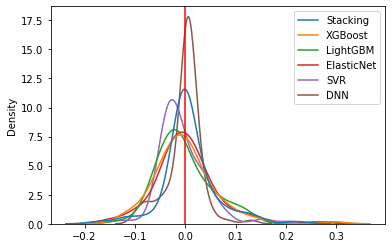

In [44]:
stack_gen.fit(features,label)
xgb.fit(features,label)
lgbm.fit(features,label)
enet.fit(features,label)
svr.fit(features,label)
dnn.fit(features,label)
dict_svr_kde = {'Stacking': label - stack_gen.predict(features),'XGBoost': label - xgb.predict(features),'LightGBM': label - lgbm.predict(features),'ElasticNet': label - enet.predict(features),'SVR': label - svr.predict(features),'DNN': label - dnn.predict(features)}
SVR_KDE_df = pd.DataFrame(dict_svr_kde)
sns.kdeplot(data = SVR_KDE_df,shade = False, common_norm = False)
plt.axvline(0, color='red')

En analysant les résidus, on constate que le modèle de stacking respecte bien les critères d'homoscedasticité.